## imports dataframe

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aqleemkhan_spotify_songs_path = kagglehub.dataset_download('aqleemkhan/spotify-songs')

print('Data source import complete.')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12.9M/12.9M [00:03<00:00, 3.39MB/s]

Extracting files...


Data source import complete.


# Sistema de Recomendação de Músicas Usando Dataset do Spotify

Este trabalho desenvolve um sistema de recomendação que antecipa as preferências musicais de dois tipos de usuários:

1. **Usuários com histórico**: Recebem recomendações personalizadas com base nas músicas que já escutaram anteriormente, considerando nome, artista e ano.
2. **Usuários novos**: Recebem recomendações baseadas nas músicas mais populares ou nas preferências dos amigos conectados.

Exploramos diferentes algoritmos de agrupamento (K-Means, DBSCAN, Agglomerative Clustering) e cenários de parametrização para melhorar as recomendações.

## Preparação do Ambiente
### Importando Bibliotecas
Primeiro, importamos as bibliotecas necessárias para análise e visualização de dados. Utilizamos bibliotecas como pandas para manipulação de dados, sklearn para algoritmos de recomendação, e seaborn para gráficos.


In [6]:
# Importando bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GridSearchCV

# Configurando o estilo dos gráficos
sns.set(style="whitegrid")

## Carregamento e Análise Inicial dos Dados

Nesta seção, vamos explorar o dataset e entender suas principais características, como o nome da música, artista, ano, popularidade e outras variáveis que serão usadas para o sistema de recomendação. Vamos também verificar se há valores nulos e quais colunas serão utilizadas para criar as recomendações.

In [7]:
# Carregando o dataset
df = pd.read_csv(f"{aqleemkhan_spotify_songs_path}/data.csv")
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [8]:
num_linhas, num_colunas = df.shape

print(f"O arquivo tem {num_linhas} músicas e {num_colunas} variáveis de atributos.")

O arquivo tem 170653 músicas e 19 variáveis de atributos.


In [9]:
# Garantindo que a coluna de ano está no formato correto
df["year"] = pd.to_numeric(df["year"], errors="coerce")

# Encontrando o ano mais antigo e o mais recente
ano_mais_antigo = int(df["year"].min())
ano_mais_novo = int(df["year"].max())

print(f"As músicas do dataset vão do ano {ano_mais_antigo} até {ano_mais_novo}.")

As músicas do dataset vão do ano 1921 até 2020.


## Pré-processamento dos Dados

O pré-processamento é uma etapa importante para garantir que os dados estejam prontos para serem usados no modelo. Aqui, removemos valores nulos, selecionamos as colunas mais relevantes e criamos uma coluna que combina o nome da música, artista e ano, o que enriquecerá a análise de similaridade.


In [10]:
# Removendo valores nulos
df = df.dropna()

# Selecionando as características que serão usadas no modelo
features = ['danceability', 'energy', 'valence', 'tempo', 'popularity']

# Incluindo colunas de nome, artista e ano
df['musica_artista_ano'] = df['name'] + ' - ' + df['artists'] + ' (' + df['year'].astype(str) + ')'
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,musica_artista_ano
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,"Piano Concerto No. 3 in D Minor, Op. 30: III. ..."
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Clancy Lowered the Boom - ['Dennis Day'] (1921)
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,Gati Bali - ['KHP Kridhamardawa Karaton Ngayog...
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Danny Boy - ['Frank Parker'] (1921)
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,When Irish Eyes Are Smiling - ['Phil Regan'] (...


## Normalização dos Dados

Para que as características sejam comparáveis, normalizamos os dados. Isso é essencial para que os algoritmos de agrupamento funcionem corretamente.

In [11]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

## Amostragem dos Dados

Para otimizar o uso de memória, realizamos uma amostragem de 30% do dataset original. Isso nos permite trabalhar com um conjunto de dados menor, mantendo a representatividade das características musicais.

In [12]:
# Amostrando 30% do dataset para reduzir o uso de memória
df_sampled = df.sample(frac=0.3, random_state=42)
scaled_data_sampled = scaler.fit_transform(df_sampled[features])

## Algoritmos de Agrupamento

### Algoritmo K-Means

Utilizamos o algoritmo K-Means para agrupar as músicas em 8 clusters. O K-Means é eficiente em termos de memória e bem adequado para este tipo de análise. Definimos explicitamente o parâmetro `n_init=10` para garantir a estabilidade dos resultados e evitar avisos futuros.

In [13]:
# Aplicação do algoritmo K-Means com 8 clusters em dados amostrados
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
df_sampled['cluster_kmeans'] = kmeans.fit_predict(scaled_data_sampled)

#### Redução de Dimensionalidade e Visualização

Para facilitar a visualização dos clusters, aplicamos a técnica de redução de dimensionalidade PCA (Principal Component Analysis), reduzindo as características musicais para 2 dimensões. O gráfico abaixo mostra a distribuição das músicas nos 8 clusters gerados pelo K-Means.

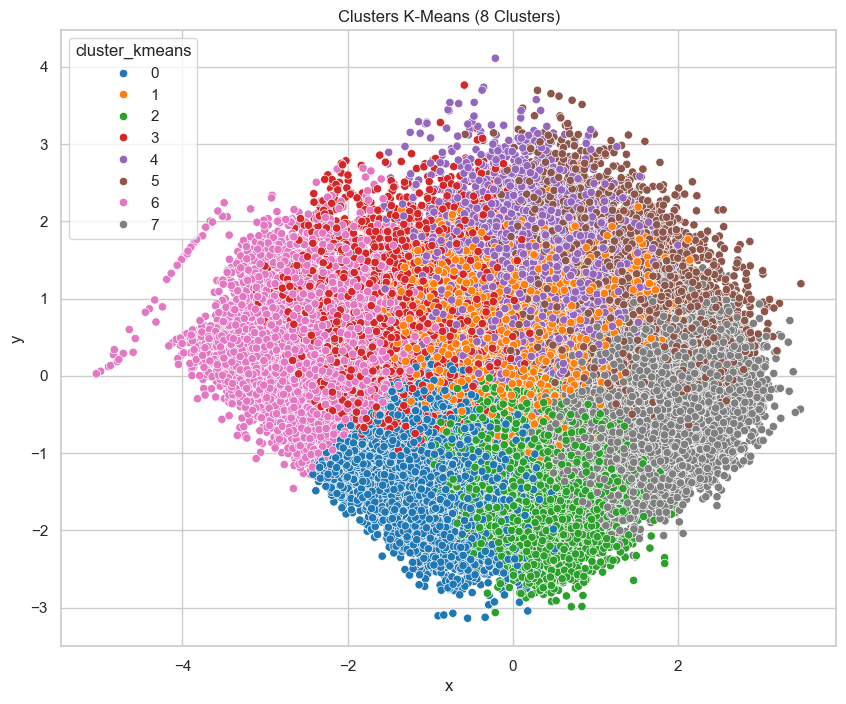

In [14]:
# Redução de dimensionalidade com IncrementalPCA para melhorar o uso de memória
pca = IncrementalPCA(n_components=2, batch_size=500)
reduced_data = pca.fit_transform(scaled_data_sampled)

df_sampled['x'] = reduced_data[:, 0]
df_sampled['y'] = reduced_data[:, 1]

# Plotando os clusters para K-Means
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='cluster_kmeans', palette='tab10', data=df_sampled)
plt.title('Clusters K-Means (8 Clusters)')
plt.show()


### Aplicação do Algoritmo DBSCAN
O DBSCAN (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de clustering que forma grupos baseados em densidade. Ele é útil para detectar clusters em dados que possuem formas arbitrárias e identificar pontos de dados como ruídos se estiverem muito distantes de outros.

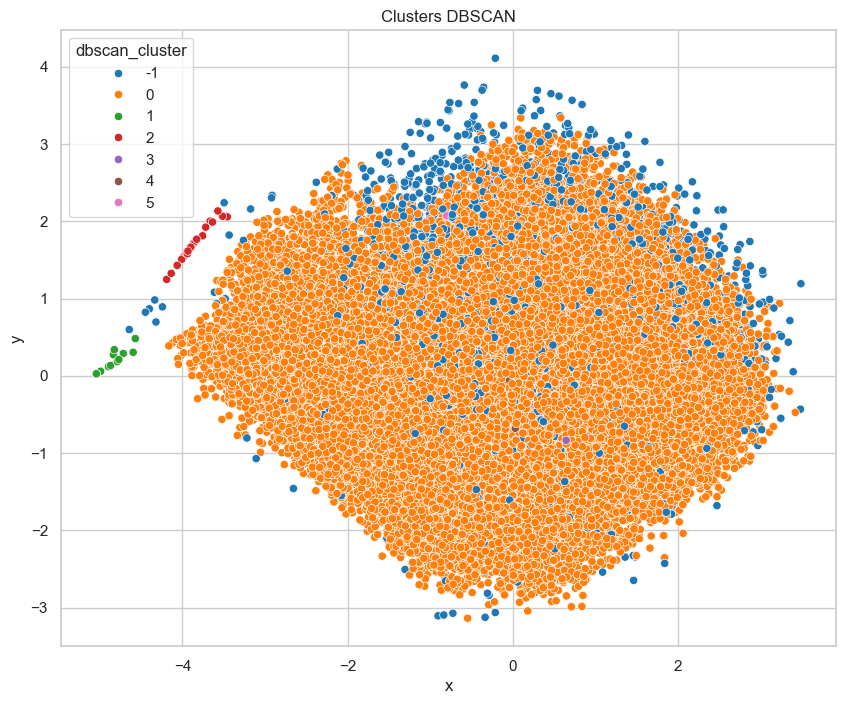

In [15]:
# DBSCAN (ajustar eps e min_samples para performance e memória)
dbscan = DBSCAN(eps=0.5, min_samples=10)
df_sampled['dbscan_cluster'] = dbscan.fit_predict(scaled_data_sampled)

# Plot para visualizar DBSCAN
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='dbscan_cluster', palette='tab10', data=df_sampled)
plt.title('Clusters DBSCAN')
plt.show()

### Aplicação do Algoritmo Agglomerative Clustering
O Agglomerative Clustering é um método de agrupamento hierárquico que começa com cada ponto de dado em seu próprio cluster e, gradualmente, agrupa os clusters mais próximos até que o número desejado de clusters seja alcançado. Esse algoritmo é útil para descobrir hierarquias naturais nos dados.

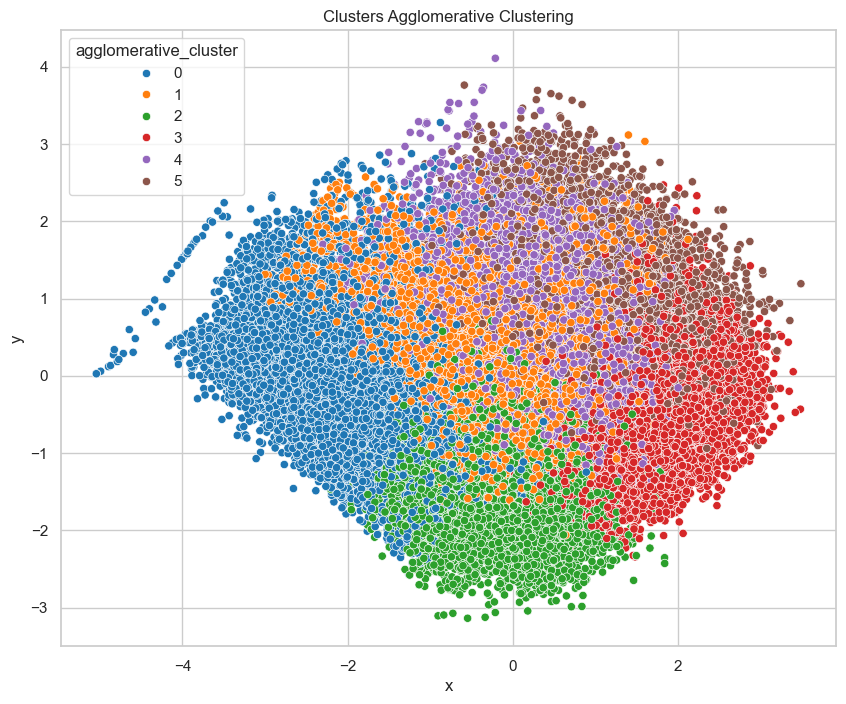

In [44]:
# Aplicando Agglomerative Clustering com 6 clusters
agglomerative = AgglomerativeClustering(n_clusters=6)
df_sampled['agglomerative_cluster'] = agglomerative.fit_predict(scaled_data_sampled)

# Plot para visualizar Agglomerative Clustering
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='agglomerative_cluster', palette='tab10', data=df_sampled)
plt.title('Clusters Agglomerative Clustering')
plt.show()

### Aplicação do Algoritmo Gaussian Mixture Model (GMM)
O Gaussian Mixture Model (GMM) é um modelo probabilístico que assume que os dados são uma mistura de várias distribuições gaussianas. É um algoritmo mais flexível que pode ser usado para detectar clusters com formas elípticas, permitindo sobreposição entre clusters.

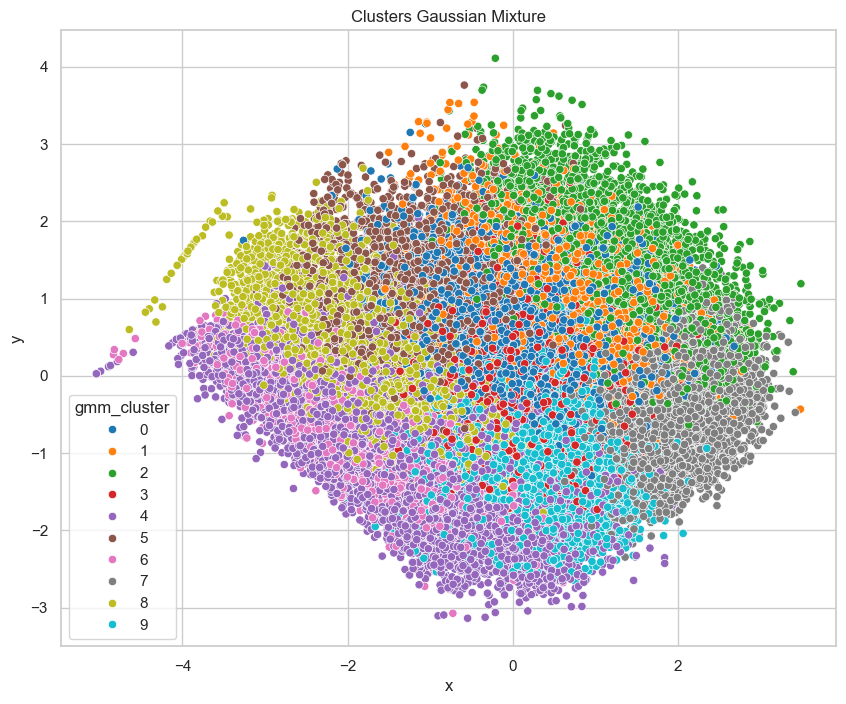

In [45]:
# Aplicando Gaussian Mixture Model (GMM) com 10 componentes
gmm = GaussianMixture(n_components=10, random_state=42)
df_sampled['gmm_cluster'] = gmm.fit_predict(scaled_data_sampled)

# Plot para visualizar GMM
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='gmm_cluster', palette='tab10', data=df_sampled)
plt.title('Clusters Gaussian Mixture')
plt.show()

## Refinando o K-Means com GridSearchCV
Vamos explorar diferentes parametrizações para o algoritmo K-Means, como o número de clusters (`n_clusters`), método de inicialização (`init`), e outras configurações usando GridSearchCV para encontrar os melhores parâmetros.


In [46]:
# Função personalizada que não requer y_true
def silhouette_scorer(estimator, X, y=None):
    cluster_labels = estimator.fit_predict(X)
    # Calcula o silhouette score para os dados
    return silhouette_score(X, cluster_labels)

# Parâmetros para o K-Means
param_grid = {
    'n_clusters': [5, 10, 15],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'random_state': [42]
}

# Reduzindo o tamanho da amostra para o GridSearchCV
df_grid_sample = df.sample(frac=0.05, random_state=42)
scaled_data_grid_sample = scaler.fit_transform(df_grid_sample[features])

# Configurando o K-Means
kmeans = KMeans()

# Aplicando GridSearchCV usando a função silhouette_scorer
grid_search = GridSearchCV(
    estimator=kmeans,
    param_grid=param_grid,
    cv=3,
    scoring=silhouette_scorer,
    n_jobs=-1  # Utiliza todos os núcleos disponíveis
)

# Treinando o GridSearchCV
grid_search.fit(scaled_data_grid_sample)

# Melhor estimador e clusterização nos dados amostrados
melhor_kmeans = grid_search.best_estimator_
df_sampled['best_kmeans_cluster'] = melhor_kmeans.predict(scaled_data_sampled)

print(f"Melhores parâmetros do K-Means: {grid_search.best_params_}")


Melhores parâmetros do K-Means: {'init': 'k-means++', 'n_clusters': 5, 'n_init': 20, 'random_state': 42}


## Comparando a Performance dos Algoritmos
Para avaliar a qualidade dos clusters gerados por cada algoritmo, vamos calcular o Silhouette Score, que mede o quão bem os dados estão agrupados.


In [47]:
# Calculando o Silhouette Score para cada algoritmo em dados amostrados
kmeans_score = silhouette_score(scaled_data_sampled, df_sampled['cluster_kmeans'])
best_kmeans_score = silhouette_score(scaled_data_sampled, df_sampled['best_kmeans_cluster'])
dbscan_score = silhouette_score(scaled_data_sampled, df_sampled['dbscan_cluster'])
agglomerative_score = silhouette_score(scaled_data_sampled, df_sampled['agglomerative_cluster'])
gmm_score = silhouette_score(scaled_data_sampled, df_sampled['gmm_cluster'])

print(f"Silhouette Score para K-Means: {kmeans_score}")
print(f"Silhouette Score para Best K-Means: {best_kmeans_score}")
print(f"Silhouette Score para DBSCAN: {dbscan_score}")
print(f"Silhouette Score para Agglomerative: {agglomerative_score}")
print(f"Silhouette Score para GMM: {gmm_score}")


Silhouette Score para K-Means: 0.19582795295940647
Silhouette Score para Best K-Means: 0.2182214777283686
Silhouette Score para DBSCAN: -0.07441567985646642
Silhouette Score para Agglomerative: 0.141756905424966
Silhouette Score para GMM: 0.07117514197000598


### O Silhouette Score (ou Coeficiente de Silhueta) é uma métrica fundamental utilizada para avaliar a qualidade dos agrupamentos (clusters) em algoritmos de aprendizado de máquina não supervisionado. Ele mede quão bem definido está cada ponto dentro do seu próprio cluster em relação aos clusters vizinhos. 

### Como Funciona O cálculo do Silhouette Score para um ponto de dado individual considera duas medidas: Coesão (a) e Separação (b)

## Interpretação do Score O valor do Silhouette Score varia de -1 a +1. 
## A interpretação é a seguinte: 
### - Valores próximos de +1: Indicam que o ponto está bem agrupado. A coesão interna é alta e a separação dos outros clusters é grande, sugerindo clusters densos e bem separados.
### - Valores próximos de 0: Indicam que o ponto está muito próximo da fronteira entre dois clusters. Isso sugere sobreposição ou que o ponto poderia estar no cluster vizinho, indicando uma qualidade de agrupamento questionável.
### - Valores próximos de -1: Indicam que o ponto provavelmente foi atribuído ao cluster errado, pois está mais próximo, em média, dos pontos do cluster vizinho do que dos pontos do seu próprio cluster. 

## Escolha do Algoritmo para Recomendação

Após comparar a performance dos algoritmos de clustering, selecionamos o K-Means como base para o sistema de recomendação. Esta escolha se deve à sua simplicidade e eficiência em agrupar músicas com características similares, formando uma base sólida para as recomendações.


## Recomendação para Usuários com Histórico

Para usuários com histórico, consideramos não apenas o nome da música, mas também o artista e o ano. O sistema calcula a similaridade com outras músicas usando essas informações, oferecendo recomendações mais detalhadas e personalizadas.

In [48]:
def recomendar_para_usuario_com_historico(historico, df, n_recomendacoes=5, peso_popularidade=1.2):
    try:
        # Filtra o DataFrame para encontrar músicas exatas com base no histórico fornecido
        historico_features = df[df['musica_artista_ano'].isin(historico)][features]

        # Verifica se o histórico contém dados válidos após a filtragem
        if historico_features.empty:
            return "Não foi possível encontrar músicas com base no histórico fornecido."

        # Calcula a média das características das músicas ouvidas
        media_features = historico_features.mean()

        # Ajusta o peso da popularidade
        media_features['popularity'] *= peso_popularidade

        # Normaliza a média das características
        media_features_scaled = scaler.transform(pd.DataFrame(media_features).T)

        # Calcula similaridade entre a média ponderada e as músicas no dataset
        similaridades = cosine_similarity(media_features_scaled, scaler.transform(df[features]))[0]

        # Seleciona os índices das músicas com maior similaridade
        indices = similaridades.argsort()[-n_recomendacoes:][::-1]

        # Retorna as músicas recomendadas com base na similaridade e popularidade
        return df.iloc[indices][['musica_artista_ano', 'popularity']]

    except IndexError:
        return "Erro ao calcular as recomendações."

## Recomendação para Novos Usuários

Para novos usuários, o sistema oferece duas opções de recomendação:

1. **Baseado nos amigos conectados**: Caso o usuário tenha amigos na plataforma, utilizamos o histórico musical desses amigos para sugerir músicas.
2. **Baseado em popularidade**: Caso o usuário não tenha amigos conectados, sugerimos as músicas mais populares da plataforma.

In [49]:
def recomendar_para_novo_usuario(df, amigos=None, n_recomendacoes=5):
    if amigos:
        # Filtra o DataFrame para encontrar músicas que correspondam ao histórico dos amigos
        recomendacoes = df[df['musica_artista_ano'].isin(amigos)]

        # Verifica se o número de recomendações é suficiente
        if len(recomendacoes) < n_recomendacoes:
            # Completa com músicas populares, excluindo as já recomendadas
            populares = df[~df['musica_artista_ano'].isin(recomendacoes['musica_artista_ano'])]
            populares = populares.sort_values(by='popularity', ascending=False)
            recomendacoes = pd.concat([recomendacoes, populares.head(n_recomendacoes - len(recomendacoes))])

        # Seleciona as colunas principais e limita ao número de recomendações
        return recomendacoes[['musica_artista_ano', 'popularity']].head(n_recomendacoes)
    else:
        # Recomendação baseada apenas nas músicas mais populares para novos usuários sem amigos
        return df.sort_values(by='popularity', ascending=False).head(n_recomendacoes)[['musica_artista_ano', 'popularity']]


## Integração das Abordagens

A função principal decide qual abordagem aplicar com base no tipo de usuário. Se o usuário tem um histórico de músicas, utilizamos as informações de suas músicas favoritas para gerar recomendações. Caso contrário, aplicamos as técnicas para novos usuários.


In [50]:
def recomendar_musicas(usuario, df, historico=None, amigos=None, n_recomendacoes=5):
    if historico:
        print(f"Recomendações para usuário com histórico:")
        return recomendar_para_usuario_com_historico(historico, df, n_recomendacoes)
    else:
        print(f"Recomendações para novo usuário:")
        return recomendar_para_novo_usuario(df, amigos, n_recomendacoes)


## Exemplos de Uso

Aqui testamos o sistema de recomendação com dois tipos de usuários:

1. **Usuário com histórico**: Recebe recomendações com base nas músicas "Shape of You" e "Blinding Lights".
2. **Novo usuário**: Recebe recomendações baseadas nos artistas que seus amigos mais ouvem, como Ed Sheeran e The Weeknd.

A saída das recomendações pode ser observada logo abaixo.


In [51]:
# Função de formatação de recomendações
def formatar_recomendacoes(resultados):
    """Formata e imprime as recomendações de forma legível."""
    if isinstance(resultados, str):  # Verifica se resultados é uma mensagem de erro
        return resultados

    recomendacoes_formatadas = []
    for _, row in resultados.iterrows():
        musica = row['musica_artista_ano']
        popularidade = row['popularity']
        recomendacoes_formatadas.append(f"Música: {musica}\nPopularidade: {popularidade}\n")

    return "\n".join(recomendacoes_formatadas)

# Exemplo de histórico e amigos no novo formato
historico = ["Hallucinate - ['Dua Lipa'] (2020)", "Shape of You - ['Ed Sheeran'] (2017)"]
amigos = ["March To The Sea - ['Twenty One Pilots'] (2009)", "Stressed Out - ['Twenty One Pilots'] (2015)"]

# Recomendação para usuário com histórico
print("Recomendações para usuário com histórico:")
recomendacoes_usuario = recomendar_para_usuario_com_historico(historico, df)
print(formatar_recomendacoes(recomendacoes_usuario))
print("="*50 + "\n")

# Recomendação para novo usuário com amigos
print("Recomendações para novo usuário com amigos:")
recomendacoes_novo_usuario = recomendar_para_novo_usuario(df, amigos)
print(formatar_recomendacoes(recomendacoes_novo_usuario))

Recomendações para usuário com histórico:
Música: Cut My Lip - ['Twenty One Pilots'] (2018)
Popularidade: 64

Música: Disfruto Lo Malo - ['Junior H', 'Natanael Cano'] (2019)
Popularidade: 74

Música: Tarzan Boy - ['Baltimora'] (1985)
Popularidade: 68

Música: Sunshine Of Your Love - ['Cream'] (2004)
Popularidade: 71

Música: Baby - ['Eslabon Armado'] (2020)
Popularidade: 70


Recomendações para novo usuário com amigos:
Música: Stressed Out - ['Twenty One Pilots'] (2015)
Popularidade: 84

Música: March To The Sea - ['Twenty One Pilots'] (2009)
Popularidade: 54

Música: Dakiti - ['Bad Bunny', 'Jhay Cortez'] (2020)
Popularidade: 100

Música: Mood (feat. iann dior) - ['24kGoldn', 'iann dior'] (2020)
Popularidade: 99

Música: Dynamite - ['BTS'] (2020)
Popularidade: 97



# Funções de avaliação: Precision@K e Recall@K

In [52]:
def precision_at_k(recomendacoes, historico_real, k=5):
    """
    Calcula a precisão das recomendações.
    Precision@K = músicas relevantes recomendadas / K
    """
    recomendadas = set(recomendacoes['musica_artista_ano'].head(k))
    relevantes = set(historico_real)

    true_positives = len(recomendadas.intersection(relevantes))
    return true_positives / k


def recall_at_k(recomendacoes, historico_real, k=5):
    """
    Calcula a cobertura das recomendações.
    Recall@K = músicas relevantes recomendadas / total de músicas relevantes
    """
    recomendadas = set(recomendacoes['musica_artista_ano'].head(k))
    relevantes = set(historico_real)

    total_relevantes = len(relevantes)
    if total_relevantes == 0:
        return 0

    true_positives = len(recomendadas.intersection(relevantes))
    return true_positives / total_relevantes


# Validação das recomendações para novo usuário com amigos

In [53]:
print("\nValidação para novo usuário com amigos:")

historico_dos_amigos = amigos

precision_amigos = precision_at_k(recomendacoes_novo_usuario, historico_dos_amigos, k=5)
recall_amigos = recall_at_k(recomendacoes_novo_usuario, historico_dos_amigos, k=5)

print(f"Precision@5 (amigos): {precision_amigos:.2f}")
print(f"Recall@5 (amigos): {recall_amigos:.2f}")



Validação para novo usuário com amigos:
Precision@5 (amigos): 0.40
Recall@5 (amigos): 1.00


# Validação das recomendações para usuário com histórico

In [54]:
print("Validação para usuário com histórico:")

# As músicas relevantes são exatamente o próprio histórico
historico_real = historico

precision = precision_at_k(recomendacoes_usuario, historico_real, k=5)
recall = recall_at_k(recomendacoes_usuario, historico_real, k=5)

print(f"Precision@5: {precision:.2f}")
print(f"Recall@5: {recall:.2f}")


Validação para usuário com histórico:
Precision@5: 0.00
Recall@5: 0.00


É possível notar que para um usuário com histórico a resposta do validador é 0 pois o agoritmo de validação apenas faz a validação de itens que estejam contidos no histórico original e como as recomendações geram músicas diferentes das já escutadas o resultado é 0. Para isso é necessário utilizar *NDCG Score*, outro tipo de algoritmo de validação.

# Validação das recomendações para usuário com histórico com NDCG Score

In [55]:
def validar_usuario_com_historico(historico, df, n_recomendacoes=5):

    historico_df = df[df['musica_artista_ano'].isin(historico)]
    if historico_df.empty:
        return "Histórico não encontrado no dataset."

    # Vetor médio como DataFrame com nomes de colunas
    vetor_historico = pd.DataFrame(
        [historico_df[features].mean()],
        columns=features
    )

    # Aplicação do scaler SEM perder nomes das features
    vetor_historico_scaled = pd.DataFrame(
        scaler.transform(vetor_historico),
        columns=features
    )

    recomendacoes = recomendar_para_usuario_com_historico(historico, df, n_recomendacoes)
    if isinstance(recomendacoes, str):
        return recomendacoes

    rec_df = df[df['musica_artista_ano'].isin(recomendacoes['musica_artista_ano'])]

    # Escalando DataFrames com feature names corretos
    df_scaled = pd.DataFrame(scaler.transform(df[features]), columns=features)
    rec_scaled = pd.DataFrame(scaler.transform(rec_df[features]), columns=features)

    # Similaridade entre histórico e todas as músicas
    similaridades = cosine_similarity(vetor_historico_scaled, df_scaled)[0]

    # Similaridade das recomendações
    similaridades_recs = cosine_similarity(vetor_historico_scaled, rec_scaled)[0]

    # Vetores para NDCG
    y_true = np.sort(similaridades)[-n_recomendacoes:]
    y_score = similaridades_recs

    ndcg = ndcg_score([y_true], [y_score], k=n_recomendacoes)

    # Distância média (já sem warnings)
    distancias = np.linalg.norm(
        rec_scaled.values - vetor_historico_scaled.values,
        axis=1
    )
    distancia_media = distancias.mean()

    return {
        f"NDCG@{n_recomendacoes}": float(ndcg),
        "Distancia_media": float(distancia_media),
        "Recomendacoes": rec_df[['musica_artista_ano', 'popularity']].reset_index(drop=True)
    }


In [65]:
df.query('artists.str.contains("AC/DC", case=False) ', engine='python').tail(30)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,musica_artista_ano
135916,0.816,1995,0.008620,['AC/DC'],0.387,272640,0.740,0,56OSb0BpuPI9tp4tDvhC8i,0.000113,7,0.3450,-5.822,1,Cover You in Oil,45,1995-09-22,0.0476,197.839,Cover You in Oil - ['AC/DC'] (1995)
138366,0.442,2008,0.000323,['AC/DC'],0.501,205107,0.889,0,3Axmw41lmMoXih3NJYzbXb,0.001640,4,0.1860,-3.890,0,Black Ice,54,2008-10-20,0.0296,94.370,Black Ice - ['AC/DC'] (2008)
138777,0.395,2010,0.002480,['AC/DC'],0.415,238907,0.886,0,3mCfSExH1q3d2lLnddgiWV,0.001670,2,0.5140,-5.195,1,Have a Drink on Me,49,2010-04-29,0.0609,122.391,Have a Drink on Me - ['AC/DC'] (2010)
149240,0.572,1988,0.213000,['AC/DC'],0.603,248427,0.819,0,3C2qc99Ay92Iv43DknVttB,0.002810,5,0.3710,-4.037,0,Meanstreak,36,1988-02-01,0.0401,97.957,Meanstreak - ['AC/DC'] (1988)
149362,0.199,1988,0.014200,['AC/DC'],0.432,272280,0.988,0,3TzodHWz58jKxePzBDqHf0,0.007860,9,0.0841,-4.442,1,This Means War,36,1988-02-01,0.1000,111.276,This Means War - ['AC/DC'] (1988)
149415,0.380,1988,0.003310,['AC/DC'],0.499,266440,0.763,0,1a6B2hBwnJoqETESO6NDj3,0.011100,2,0.2260,-5.410,1,Go Zone,35,1988-02-01,0.0359,100.493,Go Zone - ['AC/DC'] (1988)
150053,0.248,1992,0.000063,['AC/DC'],0.317,360360,0.931,0,3aSUhKMYQkfEOjkdBwWcoC,0.653000,2,0.8780,-5.794,1,Hells Bells - Live - 1991,42,1992-10-27,0.0576,113.007,Hells Bells - Live - 1991 - ['AC/DC'] (1992)
150724,0.468,1995,0.006800,['AC/DC'],0.485,246973,0.603,0,2eeDDhFzhTi78mVOQMEnDw,0.034900,9,0.2270,-6.608,1,Boogie Man,45,1995-09-22,0.0594,111.756,Boogie Man - ['AC/DC'] (1995)
151630,0.920,2000,0.006900,['AC/DC'],0.547,235693,0.722,0,3rwdLlTki1Y5YLU9DOU4ks,0.000113,7,0.0640,-3.859,1,Give It Up,48,2000-02-25,0.0317,129.616,Give It Up - ['AC/DC'] (2000)
155380,0.822,2020,0.000021,['AC/DC'],0.599,185133,0.787,0,6ZtrGCcn38kGImt2GPFbJB,0.000053,2,0.0640,-4.708,1,Shot In The Dark,75,2020-10-07,0.0338,114.065,Shot In The Dark - ['AC/DC'] (2020)


In [71]:
resultado_validacao = validar_usuario_com_historico(
    historico=[
        "Paint It, Black - ['The Rolling Stones'] (1989)",
        "T.N.T. - ['AC/DC'] (1976)",
        "Code Red - ['AC/DC'] (2020)"
    ],
    df=df,
    n_recomendacoes=4
)

resultado_validacao


{'NDCG@4': 0.9998867190971569,
 'Distancia_media': 0.6140599331996202,
 'Recomendacoes':                                   musica_artista_ano  popularity
 0              Love Song - ['Sara Bareilles'] (2007)          75
 1            Good Weed Bad B*tch - ['K CAMP'] (2014)          57
 2  Sugar (feat. Francesco Yates) - ['Robin Schulz...          77
 3        Don't Need No Reason - ['Lee Brice'] (2020)          62}

In [72]:
resultado_validacao = validar_usuario_com_historico(
    historico=[
        "Hallucinate - ['Dua Lipa'] (2020)",
        "Shape of You - ['Ed Sheeran'] (2017)"
    ],
    df=df,
    n_recomendacoes=4
)

resultado_validacao


{'NDCG@4': 0.9995888399758032,
 'Distancia_media': 0.9065627727569477,
 'Recomendacoes':                                   musica_artista_ano  popularity
 0                  Tarzan Boy - ['Baltimora'] (1985)          68
 1           Sunshine Of Your Love - ['Cream'] (2004)          71
 2  Disfruto Lo Malo - ['Junior H', 'Natanael Cano...          74
 3          Cut My Lip - ['Twenty One Pilots'] (2018)          64}

## Conclusão

Este sistema de recomendação de músicas fornece sugestões personalizadas para usuários com histórico musical e opções relevantes para novos usuários, utilizando um modelo eficiente de clustering. Com isso, o sistema oferece uma experiência musical enriquecida, aproximando-se dos interesses e preferências dos ouvintes.
